# Disaster Tweets data analysis

In [22]:
import re
import string
import numpy as np
import pandas as pd
import scipy as sp
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import validators as vld
import geonamescache as geo
# %pip install spacy-curated-transformers
# spacy.cli.download('en_core_web_sm')
# spacy.cli.download('en_core_web_trf')

In [23]:
df_train = pd.read_csv('./train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [24]:
df_train.sample(n=10)

,id,keyword,location,text,target
4695,6675,landslide,Dundee,DUNDEE NEWS: Army veteran fears loose rocks fr...,1
5231,7477,obliteration,NaN,I added a video to a @YouTube playlist http://...,0
6190,8837,sirens,Australia,MarketforceÛªs ÛÏCat SharkÛ wins Sirens ro...,0
6651,9529,terrorist,NaN,Three Israeli soldiers wounded in West Bank te...,1
3280,4706,epicentre,Africa,RT @calestous: Tanzania elephant population de...,1
7109,10186,violent%20storm,South Africa,POV footage captures violent landing from insi...,1
6801,9744,tragedy,NaN,Rly tragedy in MP: Some live to recount horror...,1
7337,10503,wildfire,"Riverside, California.",Is LA at Risk for a Giant Wildfire? - Which Wa...,1
858,1240,blood,NaN,Doing dialyses to my grandpa and oh lord this ...,0
1600,2309,collapse,"Kolkata, India",Warne Ponting shocked by Australian collapse -...,0


In [25]:
df_train.fillna(value={'keyword': '', 'location': ''}, inplace=True)
df_train.sample(n=10)

,id,keyword,location,text,target
5087,7254,nuclear%20disaster,"New York, NY",Physical sense helps preserve memories of 2011...,1
1795,2575,crash,,Crash and burn ?? https://t.co/Jq2iB1Ob1X,1
6053,8651,sinkhole,,A sinkhole grows in Brooklyn: six-meter crater...,1
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
5445,7766,police,Florida,Episcopal priests on road trip with interracia...,0
4475,6365,hostages,cuba,#hot C-130 specially modified to land in a st...,1
137,197,airplane%20accident,Pennsylvania,Strict liability in the context of an airplane...,1
1152,1660,bombing,"Washington, DC",#Japan marks 70th anniversary of #Hiroshima at...,1
5103,7280,nuclear%20disaster,,Any disaster impairs mental health especially ...,1
3347,4791,evacuated,"Chicago, but Philly is home",78 passengers evacuated safely after Green Lin...,1


In [26]:
nlp = spacy.load("en_core_web_sm")
gc = geo.GeonamesCache()
PUNCTUATION = set(string.punctuation)
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
LEMM = nltk.WordNetLemmatizer()

## Analyse location

In [27]:
countries_dict = gc.get_countries_by_names()
countries = dict()
for key, item in countries_dict.items():
    name = str(key)
    countries[key] = name
    countries[item['iso']] = name

countries['USA'] = countries['United States']
countries['US'] = countries['United States']
'Germany' in countries


True

In [28]:
cities = gc.search_cities('NC', case_sensitive=False)
cities

[{'geonameid': 1120985,
  'name': 'Zaranj',
  'latitude': 30.95962,
  'longitude': 61.86037,
  'countrycode': 'AF',
  'population': 49851,
  'timezone': 'Asia/Kabul',
  'admin1code': '19',
  'alternatenames': ['Sarandsch',
   'ZAJ',
   'Zaranas',
   'Zarandj',
   'Zarandz',
   'Zarandzas',
   'Zarandzh',
   'Zarandż',
   'Zarandžas',
   'Zarang',
   'Zarani',
   'Zaranj',
   'Zaranĝ',
   'Zerenc',
   'Zhazang',
   'Zərənc',
   'zaranja',
   'zha lan ji',
   'zrnj',
   'Зарандж',
   'Зарани',
   'Заранҷ',
   'زرنج',
   'ज़रंज',
   '扎兰季']},
 {'geonameid': 363243,
  'name': 'Sarandë',
  'latitude': 39.87534,
  'longitude': 20.00477,
  'countrycode': 'AL',
  'population': 15147,
  'timezone': 'Europe/Tirane',
  'admin1code': '51',
  'alternatenames': ['Agioi',
   'Agioi Saranta',
   'Ayii Saranda',
   'Hagios Saranta',
   'Onchesmus',
   'Porto Edda',
   'Santa Quaranta',
   'Santi Quaranta',
   'Saranda',
   'Sarande',
   'Sarandë',
   'Sarandė',
   'Saranta',
   'XSA',
   'Zogaj',
   'sa

In [29]:
canadian_states = {
    'AB': 'Alberta',
    'BC': 'British Columbia',
    'MB': 'Manitoba',
    'NB': 'New Brunswick',
    'NL': 'Newfoundland and Labrador',
    'NT': 'Northwest Territories',
    'NS': 'Nova Scotia',
    'NU': 'Nunavut',
    'ON': 'Ontario',
    'PE': 'Prince Edward Island',
    'QC': 'Quebec',
    'SK': 'Saskatchewan',
    'YT': 'Yukon'
}

can_states = dict()
for key, value in canadian_states.items():
    can_states[value] = value
    can_states[key] = value

states_dict = gc.get_us_states_by_names()
us_states = dict()
for key, value in states_dict.items():
    us_states[key] = key
    us_states[value['code']] = key

us_states['IL']

'Illinois'

In [30]:
def standardize_country(country):
    if country in ['USA', 'US']:
        return 'United States'
    return country

def analyze_location(txt):
    if txt is None or len(txt)==0:
        return (None, None, None)
    
    if txt in countries:
        return (standardize_country(txt), None, None)

    doc = nlp(txt)
    tokens = [ent.text for ent in doc.ents if ent.label_=='GPE']
    country = city = state = None

    # Safeguard: detect state in US & Canada
    words = re.split(',', txt)
    if len(words) > 1:
        state_candidate = words[-1].strip()
        if state_candidate in us_states:
            state = us_states[state_candidate]
            country = 'United States'
        elif state_candidate in can_states:
            state = can_states[state_candidate]
            country = 'Canada'

    # Search for city first
    known_tokens = []
    for loc in tokens:
        name = str(loc)
        cities = sorted(gc.search_cities(name, attribute='name', case_sensitive=False), key=lambda x: int(x['population']),reverse=True)
        cities = list(filter(lambda x: x['name'].lower() == name.lower(), cities))
        if len(cities) > 0:                
            known_tokens.append(name)
            city = cities[0]['name']
            country_code = cities[0]['countrycode']
            country_candidate = countries[country_code]
            if (country and country==country_candidate) or not country:
                country = country_candidate
                if country_code == 'US':
                    state_code = cities[0]['admin1code']
                    if state_code:
                        state = us_states[state_code]
            break

    for loc in tokens:        
        name = str(loc)
        if name in known_tokens:
            continue
        if not country and name in countries:
            country = name
        elif not state and name in us_states:
            state = us_states[name]

    if country or state or city:
        return (standardize_country(country), state, city)
    return (None, None, None)

sample1 = df_train.sample(n=10).copy()
for txt in sample1['location'].values:
    output = analyze_location(txt)
    print(f'{txt} -> {output}')


# analyze_location('Annapolis, MD')
# analyze_location('Mooresville, NC')
# analyze_location('Wellington, New Zealand')
# analyze_location('Portland, OR')
# analyze_location('Paris.')
# analyze_location('Victoria, British Columbia')
# analyze_location('Bow, NH')
# analyze_location('Rogersville, MO')

 -> (None, None, None)
 -> (None, None, None)
Jamaica -> ('Jamaica', None, None)
Melbourne Australia -> (None, None, None)
Ontario, Canada -> ('United States', 'California', 'Ontario')
St. Catharines, Ontario -> ('Canada', 'Ontario', 'Ontario')
China -> ('China', None, None)
Pennsylvania, USA -> ('United States', 'Pennsylvania', None)
???? -> (None, None, None)
United States -> ('United States', None, None)


In [31]:
def build_new_cols(location):
    country, state, city = analyze_location(location)
    location_phrase = ' '.join(['' if not country else country, '' if not state else state]).strip()
    return pd.Series({'country': country, 'state': state, 'city': city, 'location_phrase': location_phrase})

df_locations = pd.DataFrame()
df_locations[['country', 'state', 'city', 'location_phrase']] = df_train['location'].apply(lambda row: build_new_cols(row))


In [32]:
df_locations.fillna('', axis=1, inplace=True)

In [33]:
df_locations.sample(n=10)

,country,state,city,location_phrase
7612,,,,
2823,,,,
6997,,,,
5581,United States,Oklahoma,Tulsa,United States Oklahoma
5123,,,,
4020,,,,
5126,,,,
218,United States,Massachusetts,Boston,United States Massachusetts
1438,Canada,,Toronto,Canada
6448,Belgium,,,Belgium


#### Extend train set with location details

In [34]:
df_train[['country', 'state', 'city', 'location_phrase']] = df_locations


In [35]:
df_train.sample(n=10)

,id,keyword,location,text,target,country,state,city,location_phrase
6443,9218,suicide%20bombing,Principality of Zeron,@RayquazaErk There are Christian terrorists to...,1,,,,
685,987,blazing,,@DanRyckert @drewscanlon He's blazing through ...,0,,,,
4647,6607,inundated,Australia,Kids are inundated with images and information...,0,Australia,,,Australia
2349,3380,demolition,,@Demolition_d best grill u fkn pleb,0,,,,
3399,4867,explode,,@NoahCRothman Bore him with minutiae serve bad...,0,,,,
6773,9705,tornado,,@Toocodtodd Hey @wyattb23 let's challenge then...,0,,,,
5792,8264,rioting,Upstate New York,I think Twitter was invented to keep us insomn...,0,,,,
5232,7478,obliteration,India,There are no four truths-of pain of desire tha...,0,India,,,India
6002,8574,screams,,In light of recent events all I would like to ...,0,,,,
3821,5432,first%20responders,,Juneau Empire - First responders turn out for ...,0,,,,


## Feature engineering

In [36]:


def is_not_stopword(word):
    return word not in STOP_WORDS

def is_not_number(token):
    return not token.isdigit()

def is_not_url(token):
    return not vld.url(token)

def remove_punctuation(input):
    return ''.join([c for c in input if c not in PUNCTUATION])

def tokenize(input):
    return nltk.word_tokenize(input.lower())

def clean_text(input):
    tokens = re.split('\\s+', input.lower())
    tokens = filter(is_not_url, tokens)
    tokens = filter(is_not_stopword, tokens)
    tokens = map(remove_punctuation, tokens)
    tokens = filter(is_not_number, tokens)
    tokens = map(LEMM.lemmatize, tokens)
    return ' '.join(tokens)


df_train['clean_text'] = df_train['text'].apply(lambda txt: clean_text(txt))


In [37]:
def move_target_rigth(df):
    target = df['target']
    df = df.drop(['target'], axis=1)
    df['target'] = target
    return df

df_train['tokenized'] = df_train['text'].apply(lambda txt: tokenize(txt))
df_train['text_length'] = df_train['text'].apply(lambda txt: len(txt)-txt.count(' '))
df_train['upper_text_length'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c.isupper()))
df_train['upper_text_factor'] = df_train['upper_text_length']/df_train['text_length']
df_train['tags_count'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c=='#'))
df_train['punct_factor'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c in PUNCTUATION)) / df_train['text_length']
df_train['ann_count'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c=='@'))
df_train['urls_count'] = df_train['text'].apply(lambda txt: len(list(filter(vld.url, txt.split(' ')))))

df_train['tokens_count'] = df_train['tokenized'].apply(lambda tokens: len(tokens))
df_train['stop_words_count'] = df_train['tokenized'].apply(lambda tokens: sum(1 for token in tokens if token in STOP_WORDS))
df_train['stop_words_factor'] = df_train['stop_words_count'] / df_train['tokens_count']
df_train['clean_tokens_count'] = df_train['tokens_count'] - df_train['stop_words_count']
df_train['clean_tokens_factor'] = df_train['clean_tokens_count'] / df_train['tokens_count']

df_train['missing_location'] = df_train['location'].apply(lambda txt: 0 if txt is np.nan else int(len(txt)==0))

df_train = move_target_rigth(df_train)

df_train.sample(n=10)


,id,keyword,location,text,country,state,city,location_phrase,clean_text,tokenized,...,punct_factor,ann_count,urls_count,tokens_count,stop_words_count,stop_words_factor,clean_tokens_count,clean_tokens_factor,missing_location,target
1834,2637,crashed,Islamabad,Army sources say 12 persons on board including...,Pakistan,,Islamabad,Pakistan,army source say person board including team do...,"[army, sources, say, 12, persons, on, board, i...",...,0.008621,0,0,26,7,0.269231,19,0.730769,0,1
4006,5689,floods,Philippines,PAGASA 7:12am: YELLOW warning - Panay Island G...,Philippines,,,Philippines,pagasa 712am yellow warning panay island guim...,"[pagasa, 7:12am, :, yellow, warning, -, panay,...",...,0.068376,0,0,24,2,0.083333,22,0.916667,0,1
1260,1816,buildings%20on%20fire,World Wide,1943: Poland - work party prisoners in the Naz...,,,,,poland work party prisoner nazi death camp tr...,"[1943, :, poland, -, work, party, prisoners, i...",...,0.034783,0,0,25,4,0.160000,21,0.840000,0,1
7511,10744,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,India,,Mumbai,India,wreckage conclusively confirmed mh370 malaysia...,"[wreckage, 'conclusively, confirmed, ', as, fr...",...,0.100000,0,1,23,8,0.347826,15,0.652174,0,1
5027,7168,mudslide,London,#GBBO The difference between Paul and Mary my ...,United Kingdom,,London,United Kingdom,gbbo difference paul mary dear paul it look li...,"[#, gbbo, the, difference, between, paul, and,...",...,0.070796,0,0,31,10,0.322581,21,0.677419,0,0
571,826,battle,Australia,#LonePine remembered around Australia as 'desc...,Australia,,,Australia,lonepine remembered around australia descendan...,"[#, lonepine, remembered, around, australia, a...",...,0.125984,1,1,22,1,0.045455,21,0.954545,0,0
5455,7781,police,"Stratford, CT",Selection September Bridgeport men charged in ...,United States,Connecticut,,United States Connecticut,selection september bridgeport men charged hom...,"[selection, september, bridgeport, men, charge...",...,0.070707,0,1,17,2,0.117647,15,0.882353,0,1
6782,9716,tragedy,,Rly tragedy in MP: Some live to recount horror...,,,,,rly tragedy mp live recount horror ûïwhen saw...,"[rly, tragedy, in, mp, :, some, live, to, reco...",...,0.086957,0,1,27,8,0.296296,19,0.703704,1,1
6041,8636,seismic,"Perenjori, WA",Panoramic Resources cuts jobs after seismic ev...,United States,Washington,,United States Washington,panoramic resource cut job seismic event,"[panoramic, resources, cuts, jobs, after, seis...",...,0.076923,0,1,10,1,0.100000,9,0.900000,0,1
1632,2358,collapsed,,I was on my way to Gary but all the Chicago en...,,,,,way gary chicago entrance closed due bridge co...,"[i, was, on, my, way, to, gary, but, all, the,...",...,0.056075,0,0,32,14,0.437500,18,0.562500,1,1


In [44]:
df_train_new = pd.merge(df_train, keywords_stats, on='keyword', how='inner')

In [45]:
df_train_new.sample(n=10)

,id,keyword,location,text,country,state,city,location_phrase,clean_text,tokenized,...,ann_count,urls_count,tokens_count,stop_words_count,stop_words_factor,clean_tokens_count,clean_tokens_factor,missing_location,target,positive_factor
1843,2696,crush,honeymoon avenue,@jaureguiswisdom lmao well i only know one and...,,,,,jaureguiswisdom lmao well know one ive crush o...,"[@, jaureguiswisdom, lmao, well, i, only, know...",...,1,0,18,8,0.444444,10,0.555556,0,0,0.108108
6592,9490,terrorism,,Truth...\nhttps://t.co/4ZQrsAQrRT\n#News\n#BBC...,,,,,truth news bbc cnn islam truth god isi terrori...,"[truth, ..., https, :, //t.co/4zqrsaqrrt, #, n...",...,0,1,28,0,0.000000,28,1.000000,1,1,0.705882
5628,8079,rescue,USA,Lunch for the crew is made. Night night it's b...,United States,,,United States,lunch crew made night night long day peacelove...,"[lunch, for, the, crew, is, made, ., night, ni...",...,0,0,17,6,0.352941,11,0.647059,0,0,0.227273
1777,2603,crashed,Definitely NOT the stables,@spicybreads @coxytown i tried downloading it ...,,,,,spicybreads coxytown tried downloading crashed...,"[@, spicybreads, @, coxytown, i, tried, downlo...",...,2,0,14,6,0.428571,8,0.571429,0,0,0.617647
1538,2272,cliff%20fall,,alex is making me watch 107 facts about minion...,,,,,alex making watch fact minion want fall cliff ...,"[alex, is, making, me, watch, 107, facts, abou...",...,0,0,17,7,0.411765,10,0.588235,1,0,0.222222
5039,7231,natural%20disaster,,Top insurer blasts lack of Australian Govt act...,,,,,top insurer blast lack australian govt action ...,"[top, insurer, blasts, lack, of, australian, g...",...,1,1,17,2,0.117647,15,0.882353,1,1,0.529412
4553,6523,injuries,Spring Tx,HEALTH FACT: 75% of muscle mass is made up of ...,,,,,health fact muscle mass made fluid drink water...,"[health, fact, :, 75, %, of, muscle, mass, is,...",...,0,1,27,7,0.259259,20,0.740741,0,0,0.272727
4238,6070,heat%20wave,International Action,Heat wave adding to the misery of internally-d...,,,,,heat wave adding misery internallydisplaced ga...,"[heat, wave, adding, to, the, misery, of, inte...",...,1,2,18,3,0.166667,15,0.833333,0,1,0.735294
6344,9114,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,Nigeria,,,Nigeria,bestnaijamade 16yr old pkk suicide bomber deto...,"[#, bestnaijamade, :, 16yr, old, pkk, suicide,...",...,0,1,20,2,0.100000,18,0.900000,0,1,0.914286
5305,7621,pandemonium,"Leeds, UK",@KhalidKKazi mate they've taken another 2 sinc...,United Kingdom,,Leeds,United Kingdom,khalidkkazi mate theyve taken another since po...,"[@, khalidkkazi, mate, they, 've, taken, anoth...",...,1,0,16,4,0.250000,12,0.750000,0,1,0.216216


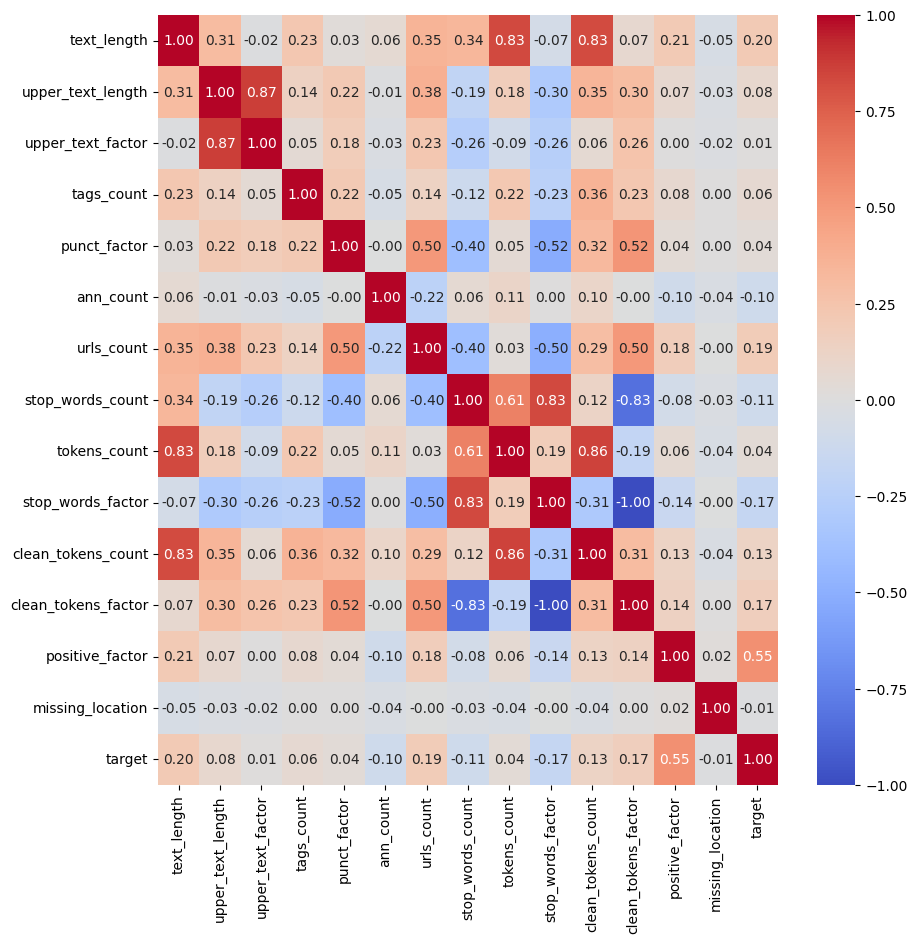

In [46]:
selected_features = ['text_length','upper_text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 'urls_count',
                     'stop_words_count', 'tokens_count', 'stop_words_factor', 'clean_tokens_count', 'clean_tokens_factor', 'positive_factor',
                     'missing_location',
                     'target']
df_corr = df_train_new[selected_features].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=df_corr.columns, yticklabels=df_corr.columns)
plt.show()

In [47]:
save_features = ['id', 'keyword', 'location', 'text', 
                 'clean_text', 
                 'country', 'state', 'city', 'location_phrase',
                 'text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 'urls_count',
                 'stop_words_factor', 'clean_tokens_factor', 
                 'positive_factor',
                 'target']

df_train_new[save_features].to_csv('./train_preprocessed.csv')